In [19]:
! pip install tensorflow-datasets

In [20]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [21]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
'cifar10',
split=['train', 'test'],
as_supervised=True,
shuffle_files=True,
with_info=True,
)

In [36]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [37]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [38]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [39]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [40]:
ds_info.features["label"].num_classes

10

In [41]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [42]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [43]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model


In [44]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [45]:
BATCH_SIZE = 256

In [46]:
EPOCH = 20

In [47]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [48]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_34.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 16, 16, 64)   832         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 16, 16, 64)   256         conv2d_32[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_136[0][0]    
____________________________________________________________________________________________

In [49]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 72s 100ms/step - loss: 2.0765 - accuracy: 0.3275 - val_loss: 2.9536 - val_accuracy: 0.1307
Epoch 2/20
195/195 [==============================] - 17s 90ms/step - loss: 1.5549 - accuracy: 0.4460 - val_loss: 2.3599 - val_accuracy: 0.2205
Epoch 3/20
195/195 [==============================] - 18s 91ms/step - loss: 1.3568 - accuracy: 0.5158 - val_loss: 1.5818 - val_accuracy: 0.4330
Epoch 4/20
195/195 [==============================] - 18s 91ms/step - loss: 1.2323 - accuracy: 0.5605 - val_loss: 1.4357 - val_accuracy: 0.4952
Epoch 5/20
195/195 [==============================] - 18s 91ms/step - loss: 1.0993 - accuracy: 0.6119 - val_loss: 1.3944 - val_accuracy: 0.5086
Epoch 6/20
195/195 [==============================] - 18s 90ms/step - loss: 1.0182 - accuracy: 0.6405 - val_loss: 1.4093 - val_accuracy: 0.5122
Epoch 7/20
195/195 [==============================] - 18s 90ms/step - loss: 0.8973 - accuracy: 0.6835 - val_loss: 1.3737 - val_accuracy

In [50]:
# 다른 모델 테스트
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_50.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   832         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_153[0][0]    
____________________________________________________________________________________________

In [51]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 26s 92ms/step - loss: 2.0275 - accuracy: 0.3173 - val_loss: 3.2602 - val_accuracy: 0.1049
Epoch 2/20
195/195 [==============================] - 18s 90ms/step - loss: 1.5691 - accuracy: 0.4433 - val_loss: 2.5982 - val_accuracy: 0.2145
Epoch 3/20
195/195 [==============================] - 18s 91ms/step - loss: 1.3793 - accuracy: 0.5060 - val_loss: 1.5337 - val_accuracy: 0.4493
Epoch 4/20
195/195 [==============================] - 18s 90ms/step - loss: 1.2619 - accuracy: 0.5502 - val_loss: 1.4323 - val_accuracy: 0.4909
Epoch 5/20
195/195 [==============================] - 18s 91ms/step - loss: 1.1281 - accuracy: 0.5984 - val_loss: 1.4316 - val_accuracy: 0.4938
Epoch 6/20
195/195 [==============================] - 18s 91ms/step - loss: 1.0286 - accuracy: 0.6376 - val_loss: 1.4448 - val_accuracy: 0.4927
Epoch 7/20
195/195 [==============================] - 18s 92ms/step - loss: 0.9062 - accuracy: 0.6815 - val_loss: 1.4537 - val_accuracy:

In [52]:
# 다른 모델 테스트
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain_resnet_34.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 16, 16, 64)   832         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_170 (BatchN (None, 16, 16, 64)   256         conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 8, 8, 64)     0           batch_normalization_170[0][0]    
___________________________________________________________________________________________

In [53]:
history_plain_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 26s 94ms/step - loss: 1.9914 - accuracy: 0.3311 - val_loss: 3.2124 - val_accuracy: 0.1048
Epoch 2/20
195/195 [==============================] - 18s 91ms/step - loss: 1.5411 - accuracy: 0.4501 - val_loss: 2.6724 - val_accuracy: 0.1988
Epoch 3/20
195/195 [==============================] - 18s 93ms/step - loss: 1.3622 - accuracy: 0.5122 - val_loss: 1.6716 - val_accuracy: 0.4020
Epoch 4/20
195/195 [==============================] - 18s 91ms/step - loss: 1.2311 - accuracy: 0.5622 - val_loss: 1.3999 - val_accuracy: 0.4999
Epoch 5/20
195/195 [==============================] - 18s 91ms/step - loss: 1.1142 - accuracy: 0.6047 - val_loss: 1.3945 - val_accuracy: 0.5147
Epoch 6/20
195/195 [==============================] - 18s 91ms/step - loss: 1.0087 - accuracy: 0.6433 - val_loss: 1.3209 - val_accuracy: 0.5338
Epoch 7/20
195/195 [==============================] - 18s 91ms/step - loss: 0.9116 - accuracy: 0.6810 - val_loss: 1.3854 - val_accuracy:

In [54]:
# 다른 모델 테스트
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain_resnet_50.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 16, 16, 64)   832         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_187 (BatchN (None, 16, 16, 64)   256         conv2d_44[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 8, 8, 64)     0           batch_normalization_187[0][0]    
___________________________________________________________________________________________

In [55]:
history_plain_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 26s 93ms/step - loss: 2.1000 - accuracy: 0.3227 - val_loss: 3.1455 - val_accuracy: 0.1276
Epoch 2/20
195/195 [==============================] - 18s 91ms/step - loss: 1.5836 - accuracy: 0.4422 - val_loss: 2.8476 - val_accuracy: 0.1628
Epoch 3/20
195/195 [==============================] - 18s 92ms/step - loss: 1.3839 - accuracy: 0.5087 - val_loss: 1.5589 - val_accuracy: 0.4473
Epoch 4/20
195/195 [==============================] - 18s 92ms/step - loss: 1.2440 - accuracy: 0.5573 - val_loss: 1.4197 - val_accuracy: 0.4997
Epoch 5/20
195/195 [==============================] - 18s 91ms/step - loss: 1.1224 - accuracy: 0.6002 - val_loss: 1.3804 - val_accuracy: 0.5186
Epoch 6/20
195/195 [==============================] - 18s 90ms/step - loss: 1.0238 - accuracy: 0.6403 - val_loss: 1.3888 - val_accuracy: 0.5235
Epoch 7/20
195/195 [==============================] - 18s 91ms/step - loss: 0.9159 - accuracy: 0.6771 - val_loss: 1.3871 - val_accuracy:

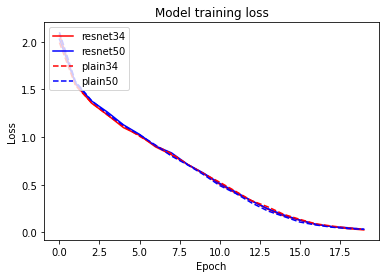

In [56]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'r', linestyle='--')
plt.plot(history_plain_50.history['loss'], 'b', linestyle='--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50','plain34', 'plain50'], loc='upper left')
plt.show()

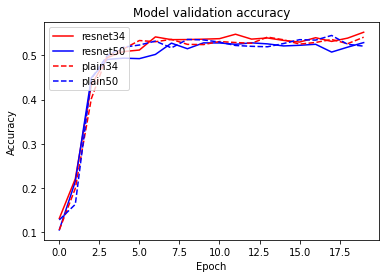

In [57]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'r', linestyle='--')
plt.plot(history_plain_50.history['val_accuracy'], 'b', linestyle='--')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50','plain34', 'plain50'], loc='upper left')
plt.show()